In [1]:
import sys
sys.path.append("../")
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import ThinLens.Elements as Elements
import ThinLens.Maps as Maps
from ThinLens.Models import F0D0Model, SIS18_Cell_minimal, SIS18_Cell, \
    SIS18_Lattice_minimal, SIS18_Lattice

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from IPython.display import set_matplotlib_formats, display
set_matplotlib_formats('pdf', "svg")
import matplotlib.pyplot as plt
import numpy as np

import cpymad.madx

from ThinLens.Beam import Beam
import tools.plot

from NewModels import F0D0Model12

In [2]:
# general
# torch.set_printoptions(precision=4, sci_mode=False)

slices = 4
quadSliceMultiplicity = 1
device = torch.device("cpu")
outputPerElement = True  # exceeds outputAtBPM
outputAtBPM = True

# set up models
# Lattice = F0D0Model12
Lattice = SIS18_Lattice_minimal

model = Lattice(slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,).to(device)

perturbedModel = Lattice(slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,).to(device)

_ = model.requires_grad_(False)
_ = perturbedModel.requires_grad_(False)

In [3]:
# perturb model
relDev = 5e-3
for element in perturbedModel.elements:
    if type(element) is Elements.Quadrupole:
        k1n = element.k1n.item()
        k1n = torch.normal(k1n, relDev*abs(k1n), size=(1,))
        element.k1n = nn.Parameter(k1n, requires_grad=False)
        element.shareWeights()

In [4]:
# train set
beam = Beam(mass=18.798, energy=19.0, exn=1.258e-6, eyn=2.005e-6, sigt=0.01, sige=0.000, particles=500)
bunch = beam.bunch[:].to(device)
label = perturbedModel(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM).to(device)

trainSet = torch.utils.data.TensorDataset(bunch, label)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=25,
                                          shuffle=True, num_workers=2)


plot initial model properties

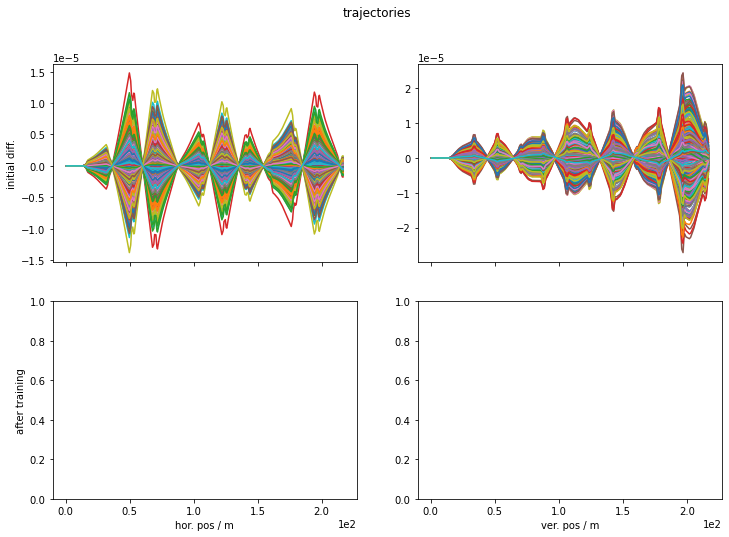

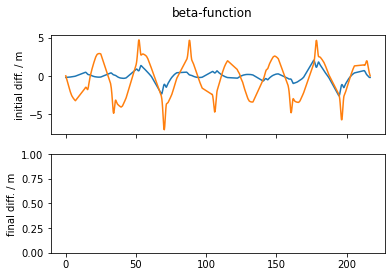

In [5]:
# plot initial trajectories
figTrajectories, axesTrajectories = plt.subplots(2, 2, sharex=True, figsize=(12,8))
figTrajectories.suptitle("trajectories")

for i in range(len(axesTrajectories)):
    for j in range(len(axesTrajectories[i])):
        axesTrajectories[i, j].ticklabel_format(style="sci", scilimits=(0,0))

initialTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)
tools.plot.trajectories(axesTrajectories[0, 0], initialTrajectoriesDifference, model, plane="x")
tools.plot.trajectories(axesTrajectories[0, 1], initialTrajectoriesDifference, model, plane="y")

axesTrajectories[0, 0].set_ylabel("initial diff.")
axesTrajectories[1, 0].set_ylabel("after training")
axesTrajectories[1, 0].set_xlabel("hor. pos / m")
axesTrajectories[1, 1].set_xlabel("ver. pos / m")

# plot inital beta
modelTwiss, perturbedTwiss = model.getTwiss(), perturbedModel.getTwiss()

figBeta, axesBeta = plt.subplots(2, sharex=True)
figBeta.suptitle("beta-function")
try:
    axesBeta[0].plot(modelTwiss["s"], modelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
    axesBeta[0].plot(modelTwiss["s"], modelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
except ThinLens.Models.TwissFailed as e:
    print(e)
    print("warning twiss failed")

axesBeta[0].set_ylabel("initial diff. / m")
axesBeta[1].set_ylabel("final diff. / m")

plt.show()

Text(0.5, 0, 'pos / m')

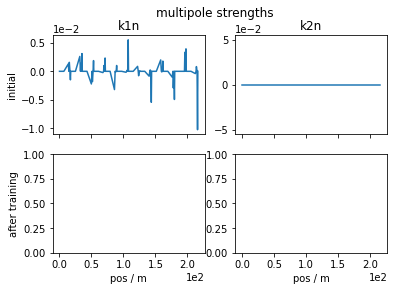

In [6]:
# visualize difference in multipole components
def compareMultipoleStrengths(modelA, modelB):
    diff_k1n, diff_k2n = np.empty(len(modelA.elements)), np.empty(len(modelA.elements))
    diff_k1s, diff_k2s = np.empty(len(modelA.elements)), np.empty(len(modelA.elements))

    for i in range(len(modelA.elements)):
        if type(modelA.elements[i]) is Elements.Quadrupole:
            diff_k1n[i] = modelA.elements[i].k1n.item() - modelB.elements[i].k1n.item()
            diff_k1s[i] = modelA.elements[i].k1s.item() - modelB.elements[i].k1s.item()
            diff_k2n[i] = modelA.elements[i].k2n.item() - modelB.elements[i].k2n.item()
            diff_k2s[i] = modelA.elements[i].k2s.item() - modelB.elements[i].k2s.item()
        else:
            diff_k1n[i] = 0
            diff_k1s[i] = 0
            diff_k2n[i] = 0
            diff_k2s[i] = 0

    return tuple([(diff_k1n, diff_k2n), (diff_k1s, diff_k2s),])

initialDiffNormal, initialDiffSkew = compareMultipoleStrengths(model, perturbedModel)

multipoleFig, multipoleAxes = plt.subplots(2, 2, sharex=True)
multipoleFig.suptitle("multipole strengths")


for i in range(len(multipoleAxes)):
    for j in range(len(multipoleAxes[i])):
        multipoleAxes[i, j].ticklabel_format(style="sci", scilimits=(0,0))

multipoleAxes[0, 0].plot(model.positions, initialDiffNormal[0])
multipoleAxes[0, 1].plot(model.positions, initialDiffNormal[1])

multipoleAxes[0, 0].set_title("k1n")
multipoleAxes[0, 1].set_title("k2n")
multipoleAxes[0, 0].set_ylabel("initial")
multipoleAxes[1, 0].set_ylabel("after training")

multipoleAxes[1, 0].set_xlabel("pos / m")
multipoleAxes[1, 1].set_xlabel("pos / m")

setup training

In [7]:
# activate gradients on kick maps
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        element.k1n.requires_grad_(True)
        element.k2n.requires_grad_(True)
        
        # currently twiss parameters cannot be calculated for coupled motion
        element.k1s.requires_grad_(False)
        element.k2s.requires_grad_(False)

# set up optimizer
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.Adagrad(model.parameters(),)
optimizer = optim.Adamax(model.parameters(),)
criterion = nn.MSELoss()


In [8]:
epochs = 250

# train loop
t0 = time.time()

for epoch in range(epochs):
    for i, data in enumerate(trainLoader, 0):
        bunch, label = data[0], data[1]

        optimizer.zero_grad()

        out = model(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)

        # loss = criterion(out, label)  # full phase-space
        loss = criterion(out[:, [0, 2], :], label[:, [0, 2], :])  # only x-, y-plane

        loss.backward()
        optimizer.step()

    # if epoch % 10 == 9:
    #     print(loss.item())
    print(loss.item())

print("training completed within {:.2f}s".format(time.time() - t0))

5.392872157920345e-13
3.060492580064604e-13
2.740444348111993e-13
1.9394161344229057e-13
1.1621639131403965e-13
1.1198986895789497e-13
8.174974283744253e-14
7.11722715779923e-14
7.76459708798974e-14
7.703331219993026e-14
5.5671972644062175e-14
5.601939191922113e-14
5.385496422655242e-14
5.051510378043864e-14
4.745096596065564e-14
3.506115019890699e-14
4.042901045690652e-14
2.3271327381146896e-14
4.6829682595809433e-14
3.1370668892985177e-14
3.494800891244606e-14
2.385064173901812e-14
2.3950305025100238e-14
2.2686174920523037e-14
2.5988994498890486e-14
2.2358259505341822e-14
3.321934003949031e-14
1.7297084102339557e-14
2.413136376681248e-14
1.6486877965667027e-14
2.2936917203718032e-14
1.945772069546655e-14
1.9654387445000185e-14
2.3758327427344916e-14
1.5393673381225747e-14
1.9406566893570663e-14
1.7305308455885566e-14
1.6400433886572324e-14
9.78078547418299e-15
1.2948995421238187e-14
1.7731280854621338e-14
1.1995840033500725e-14
1.7607242670496944e-14
1.4189994955906075e-14
1.26849494

visualize model performance after training

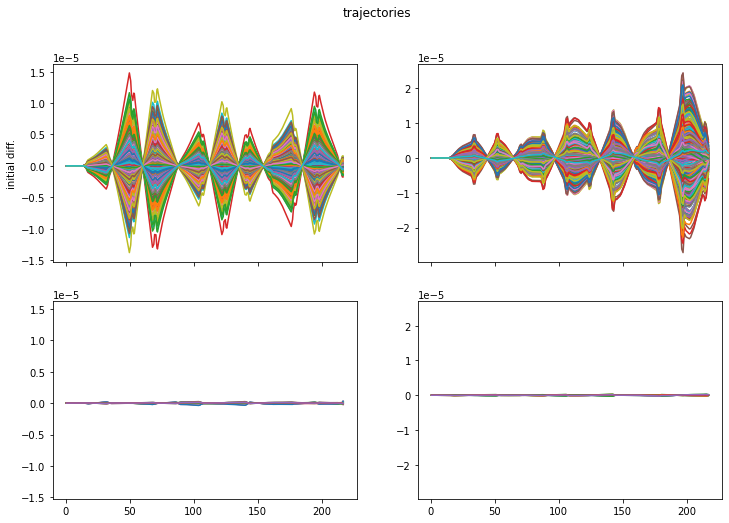

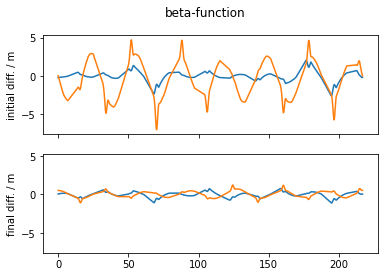

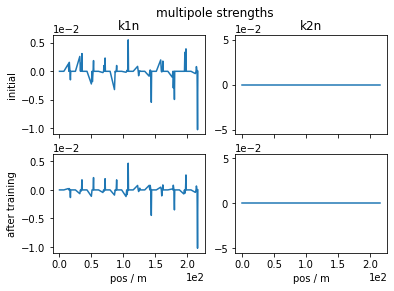

In [9]:
perturbedModel# plot final trajectories
trajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)

axesTrajectories[1, 0].clear()
tools.plot.trajectories(axesTrajectories[1, 0], trajectoriesDifference, model, plane="x")
axesTrajectories[1, 0].set_ylim(axesTrajectories[0, 0].get_ylim())

axesTrajectories[1, 1].clear()
tools.plot.trajectories(axesTrajectories[1, 1], trajectoriesDifference, model, plane="y")
axesTrajectories[1, 1].set_ylim(axesTrajectories[0, 1].get_ylim())

display(figTrajectories)


# plot final beta
finalModelTwiss = model.getTwiss()
try:
    axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
    axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
    
    axesBeta[1].set_ylim(axesBeta[0].get_ylim())
except ThinLens.Models.TwissFailed as e:
    print(e)
    print("warning twiss failed")

display(figBeta)

# plot final deviation in multipole strengths
finalDiffNormal, finalDiffSkew = compareMultipoleStrengths(model, perturbedModel)

multipoleAxes[1, 0].plot(model.positions, finalDiffNormal[0])
multipoleAxes[1, 0].set_ylim(multipoleAxes[0, 0].get_ylim())

multipoleAxes[1, 1].plot(model.positions, finalDiffNormal[1])
multipoleAxes[1, 1].set_ylim(multipoleAxes[0, 1].get_ylim())

display(multipoleFig)

look at multipole strengths

In [10]:
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        print("k2n={:.2e}, k2s={:.2e}".format(element.k2n.item(), element.k2s.item()))

k2n=-5.58e-09, k2s=0.00e+00
k2n=-1.34e-08, k2s=0.00e+00
k2n=-4.40e-09, k2s=0.00e+00
k2n=9.40e-09, k2s=0.00e+00
k2n=9.50e-09, k2s=0.00e+00
k2n=4.31e-09, k2s=0.00e+00
k2n=2.03e-08, k2s=0.00e+00
k2n=3.08e-08, k2s=0.00e+00
k2n=9.20e-09, k2s=0.00e+00
k2n=-6.12e-09, k2s=0.00e+00
k2n=-1.49e-08, k2s=0.00e+00
k2n=-4.79e-09, k2s=0.00e+00
k2n=-4.46e-10, k2s=0.00e+00
k2n=-5.26e-09, k2s=0.00e+00
k2n=-9.43e-10, k2s=0.00e+00
k2n=3.29e-09, k2s=0.00e+00
k2n=7.55e-09, k2s=0.00e+00
k2n=2.08e-09, k2s=0.00e+00
k2n=5.65e-10, k2s=0.00e+00
k2n=-1.61e-10, k2s=0.00e+00
k2n=-1.05e-10, k2s=0.00e+00
k2n=3.65e-09, k2s=0.00e+00
k2n=5.53e-09, k2s=0.00e+00
k2n=1.52e-09, k2s=0.00e+00
k2n=-1.82e-09, k2s=0.00e+00
k2n=-4.02e-09, k2s=0.00e+00
k2n=-2.01e-09, k2s=0.00e+00
k2n=-2.46e-09, k2s=0.00e+00
k2n=-4.49e-09, k2s=0.00e+00
k2n=-1.61e-09, k2s=0.00e+00
k2n=2.80e-09, k2s=0.00e+00
k2n=6.37e-09, k2s=0.00e+00
k2n=2.13e-09, k2s=0.00e+00
k2n=-1.42e-09, k2s=0.00e+00
k2n=-5.98e-10, k2s=0.00e+00
k2n=-4.47e-11, k2s=0.00e+00


In [11]:
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        print("k1n={:.2e}, k1s={:.2e}".format(element.k1n.item(), element.k1s.item()))

k1n=3.11e-01, k1s=0.00e+00
k1n=-4.79e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
k1n=3.09e-01, k1s=0.00e+00
k1n=-4.80e-01, k1s=0.00e+00
k1n=6.23e-01, k1s=0.00e+00
k1n=3.13e-01, k1s=0.00e+00
k1n=-4.76e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
k1n=3.12e-01, k1s=0.00e+00
k1n=-4.79e-01, k1s=0.00e+00
k1n=6.24e-01, k1s=0.00e+00
k1n=3.15e-01, k1s=0.00e+00
k1n=-4.78e-01, k1s=0.00e+00
k1n=6.26e-01, k1s=0.00e+00
k1n=3.11e-01, k1s=0.00e+00
k1n=-4.79e-01, k1s=0.00e+00
k1n=6.24e-01, k1s=0.00e+00
k1n=3.12e-01, k1s=0.00e+00
k1n=-4.78e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
k1n=3.14e-01, k1s=0.00e+00
k1n=-4.77e-01, k1s=0.00e+00
k1n=6.26e-01, k1s=0.00e+00
k1n=3.11e-01, k1s=0.00e+00
k1n=-4.79e-01, k1s=0.00e+00
k1n=6.24e-01, k1s=0.00e+00
k1n=3.14e-01, k1s=0.00e+00
k1n=-4.74e-01, k1s=0.00e+00
k1n=6.26e-01, k1s=0.00e+00
k1n=3.12e-01, k1s=0.00e+00
k1n=-4.82e-01, k1s=0.00e+00
k1n=6.23e-01, k1s=0.00e+00
k1n=3.12e-01, k1s=0.00e+00
k1n=-4.78e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
